# Neural Network Dev Notebook

This notebook is for development of a suitable neural network for training on the training set. Here, I use the dev set and tune hyperparameters and model structure for best performance. 

In [1]:
import keras
import glob
import os
from PIL import Image
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Lambda, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from utils import load_json, make_logger
import logging
import itertools
import pickle

params = load_json('params.json')
logger = make_logger('development', 'log/development.log')

Using TensorFlow backend.


## Load the dev set and images

Creates a dict relating artist MBIDs to spectrogram images, represented as 128x128x1 arrays of floats. Also load the previously saved database of artist relationships.

For now, we only load the first track we have on file for each artist, even if we have more. This can be changed later.

In [2]:
logger.info('Loading images')

images = defaultdict(list)

for path in tqdm_notebook(glob.glob('tracks/**/*.png', recursive=True)):
    mbid = os.path.basename(path).rsplit('-', 1)[0]
    img = np.array(Image.open(path).convert('L')) / 255
    img = np.reshape(img, img.shape + (1,))
    images[mbid].append(img)
    
logger.info('Loaded images')

Loading images


Loaded images


In [26]:
logger.info('Loading dev set')

raw_dataset = pd.read_hdf('dataset/dev_min.hd5', key='artists')

logger.info('Loaded dev set')

Loading dev set
Loaded dev set


In [27]:
logger.info('Artists in images: {}'.format(len(images)))
logger.info('Dataset length: {}'.format(len(raw_dataset)))

Artists in images: 9484
Dataset length: 9496


## Create dataset relating image references to values

Previously, we had the large raw dataset which is of the form `raw_dataset[artistA][artistB]=similarity`. Here, we create X and Y arrays, with the X array being a list of two arrays, each containing references to one of the spectrogram images that was loaded for a given artist. The Y array is a list containing the similarity scores for the corresponding two artists.

In [28]:
logger.info('Re-formatting dataset for training')

X_1 = list()
X_2 = list()
Y = list()

for index, value in tqdm_notebook(raw_dataset.iteritems(), total = len(raw_dataset)):
    X_1.append(images[index[0]][0])
    X_2.append(images[index[1]][0])
    Y.append(value)
    
X_1_train, X_1_test, X_2_train, X_2_test, Y_train, Y_test = train_test_split(X_1, X_2, Y, test_size=0.02, 
                                                                             random_state = 1)
logger.info('Training set size: {}'.format(len(Y_train)))
logger.info('Test set size: {}'.format(len(Y_test)))
X_train = [X_1_train, X_2_train]
X_test = [X_1_test, X_2_test]
# We make Y a numpy array for convenience later, this cant be done with X because it doesn't fit in memory
Y = np.array(Y)
X = [X_1, X_2]

logger.info('Dataset formatted')

Re-formatting dataset for training


Training set size: 9306
Test set size: 190
Dataset formatted


## Batch Function

Gets a batch of a specific batch size, either from the dev-train set or dev-test set. Uses random sampling with replacement.

In [29]:
def get_batch(batch_size, train = True):
    if train:
        X = X_train
        Y = Y_train
    else:
        X = X_test
        Y = Y_test
    indices = np.random.choice(len(Y), size = batch_size)
    X_batch = [list(), list()]
    X_batch[0] = [X[0][i] for i in indices]
    X_batch[1] = [X[1][i] for i in indices]
    Y_batch = [Y[i] for i in indices]
    return X_batch, Y_batch

## Define Keras model specification

This defines a siamese network, which trains the same model with the same parameters and applies it to both images. The output of this shared vector is a fully-connected network with 128 neurons, for each image. The L1 distance between these two networks is then taken and the resulting 128 length vector is fed into a final sigmoid function.

In [30]:
def L1_distance(x):
    return K.abs(x[0] - x[1])

def L1_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1

def create_base_network(input_shape):
    input = Input(shape = input_shape)
    x = ZeroPadding2D()(input) # 130x130x1
    x = Conv2D(8,(7,7),activation='tanh')(x) # 124x124x8
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 62x62x8
    x = ZeroPadding2D()(x) # 64x64x8
    x = Conv2D(16,(7,7),activation='tanh')(x) # 58x58x16
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 29x29x16
    x = ZeroPadding2D()(x) # 31x31x16
    x = Conv2D(32,(7,7),activation='tanh')(x) # 25x25x32
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 12x12x32
    x = ZeroPadding2D()(x) # 14x14x32
    x = Conv2D(64,(7,7),activation='tanh')(x) # 8x8x64
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 4x4x64
    x = ZeroPadding2D()(x) # 6x6x64
    x = Conv2D(128,(5,5),activation='tanh')(x) # 2x2x128
    x = Flatten()(x)
    x = Dense(128, activation='tanh')(x) # FC 256
    return Model(input, x)
    
def model_spec(lr = 0.001, decay = 0.0, **kwargs):
    input_shape = (128,128,1)

    siamese_net = create_base_network(input_shape)

    input_a = Input(shape = input_shape)
    input_b = Input(shape = input_shape)

    process_a = siamese_net(input_a)
    process_b = siamese_net(input_b)

    distance = Lambda(L1_distance, output_shape = L1_dist_output_shape)([process_a, process_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model([input_a, input_b], output)

    adam = Adam(lr=lr, decay=decay)
    model.compile(loss = 'mean_squared_error', optimizer = adam)
    
    return model

## Train the neural network

Define a function to randomly sample batches from the X and Y datasets, then train our model on these minibatches. Train over a certain number of iterations, updating a live plot with train and test errors. This is just for a visual representation to test out code for a fixed set of hyperparameters, more rigourous hyperparameter search is done below.

<IPython.core.display.Javascript object>


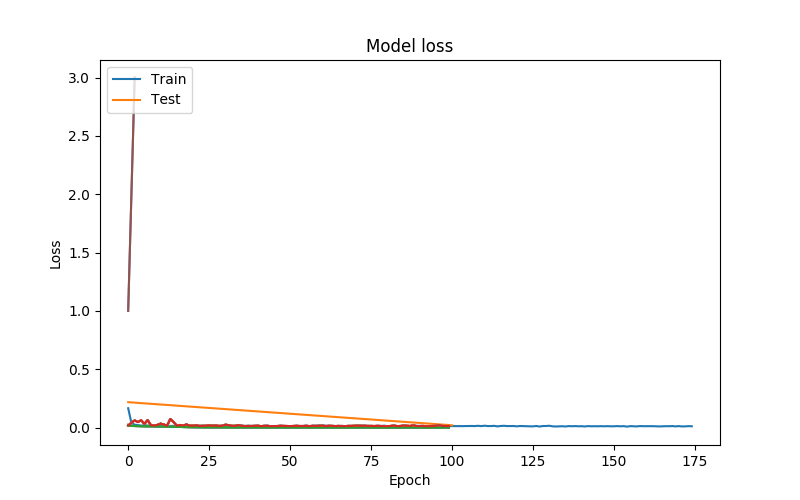

KeyboardInterrupt: 

In [19]:
%matplotlib notebook

epochs = 10
batch_size = 1024
n_iters = int(len(Y_train) / batch_size) * epochs
test_loss_every = 100

train_error = list()
test_error = list()

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8,5)
line_train, = ax1.plot(train_error)
line_test, = ax1.plot(np.array(range(len(test_error))) * test_loss_every, test_error)
ax1.set_title('Loss')
ax1.legend([line_train, line_test], ['Training Loss', 'Test Loss'])
plt.ion()

fig.show()
fig.canvas.draw()

model = model_spec()

t = tnrange(n_iters, desc='[Iteration 0]', leave=True, ncols='800px')
for i in t:
    (inputs, targets) = get_batch(batch_size)
    train_loss = model.train_on_batch(inputs, targets)
    train_error.append(train_loss)
    if i % test_loss_every == 0:
        test_loss = model.evaluate(X_test, Y_test, verbose=0)
        test_error.append(test_loss)
    t.set_description('[Iteration {}, Loss = {:.10f}]'.format(i + 1, train_loss))
    t.refresh()
    ax1.clear()
    line_train, = ax1.plot(train_error)
    line_test, = ax1.plot(np.array(range(len(test_error))) * test_loss_every, test_error)
    ax1.set_title('Loss')
    ax1.legend([line_train, line_test], ['Training Loss', 'Test Loss'])
    fig.canvas.draw()


### Save the trained model

In [31]:
model.save('models/saved_full.hd5')

## Hyperparameter Search

This function will take in a model and a hyperparameters dict, and output training and test losses after training. The following hyperparameters are implemented:

`batch_size`: batch size for training

`epochs`: number of epochs to use in the training phase (NOTE: Since we use random sampling, this is "epoch equivalents" where an epoch is equal to `int(dataset_size/batch_size)` iterations. Eventually, I will modify this to be actual epochs.

`lr`: learning rate for model

`decay`: decay for learning rate

In [32]:
def build_model_path(hparams):
    path_components = ['_'.join([key, str(val)]) for key,val in hparams.items()]
    return os.path.join('models', *path_components)

def test_hyperparams(hparams, model_spec, log=True, save=True):
    # Make the path to the logger/model directory, named based on parameters
    path = build_model_path(hparams)
    os.makedirs(path, exist_ok=True)
    
    # Get temporary logger with hparams.__str__ name 
    tmp_logger = make_logger(str(hparams), os.path.join(path, 'training.log'), log_to_console=False)
    
    batch_size = hparams['batch_size']
    n_iters = hparams['epochs'] * int(len(Y_train) / hparams['batch_size'])
    model = model_spec(**hparams)
    test_loss_every = 20

    train_error = list()
    test_error = list()

    tmp_logger.info('Training with params {}'.format(hparams))

    t = tnrange(n_iters, desc='[Iteration 0]', leave=True, ncols='800px')
    for i in t:
        (inputs, targets) = get_batch(batch_size)
        train_loss = model.train_on_batch(inputs, targets)
        train_error.append(train_loss)
        if i % test_loss_every == 0:
            test_loss = model.evaluate(X_test, Y_test, verbose=0)
            test_error.append(test_loss)
            if log:
                tmp_logger.info('Iteration {}, train loss = {:.5f}, test loss = {:.5f}'.format(i + 1, 
                                                                                               train_loss, test_loss))
        t.set_description('[Iteration {}, Train Loss = {:.5f}, Test Loss = {:.5f}]'.format(i + 1, train_loss, test_loss))
        t.refresh()
    
    tmp_logger.info('Finished training, final train loss = {:.5f}, test loss = {:.5f}'.format(train_loss, test_loss))
    
    train_error = np.asarray(train_error)
    test_error = np.asarray(test_error)
    np.savetxt(os.path.join(path, 'train_error.csv'), train_error, delimiter=',')
    np.savetxt(os.path.join(path, 'test_error.csv'), test_error, delimiter=',')
    
    if save:
        tmp_logger.info('Saving model')
        model.save(os.path.join(path, 'post_train_model.hd5'))
        tmp_logger.info('Saved model')
        

## Iterate through Hyperparameter sets and Evaluate

Create a dict containing all values for all hyperparameters we want to look at, then generate all combinations of these parameters and test each one.

In [13]:
all_hparams = {
    'batch_size': [32, 64, 128],
    'epochs': [5, 10, 25], 
    'lr': [0.1, 0.01, 0.001],
    'decay': [0.01, 0.001, 0.0]
}

hparams_list = list()
keys, vals = zip(*all_hparams.items())
for val in itertools.product(*vals):
    hparams_list.append(dict(zip(keys, val)))

logger.info('Generated hyperparameters test list, total of {} combinations'.format(len(hparams_list)))

for hparams in tqdm_notebook(hparams_list):
    test_hyperparams(hparams, model_spec)

Generated hyperparameters test list, total of 81 combinations


NameError: name 'test_hyperparams' is not defined

## Random checking below

In [35]:
hparams = {
    'batch_size': 256,
    'epochs': 10
}
#test_hyperparams(hparams, model_spec)
model = model_spec()
history = model.fit(X, Y, epochs=100, validation_split=0.01, batch_size=256)

Train on 9401 samples, validate on 95 samples
Epoch 1/100
9401/9401 [==============================] - 16s 2ms/step - loss: 0.0214 - val_loss: 0.0166
Epoch 2/100
9401/9401 [==============================] - 11s 1ms/step - loss: 0.0140 - val_loss: 0.0416
Epoch 3/100
9401/9401 [==============================] - 11s 1ms/step - loss: 0.0133 - val_loss: 0.0611
Epoch 4/100
9401/9401 [==============================] - 12s 1ms/step - loss: 0.0127 - val_loss: 0.0471
Epoch 5/100
9401/9401 [==============================] - 11s 1ms/step - loss: 0.0121 - val_loss: 0.0628
Epoch 6/100
9401/9401 [==============================] - 11s 1ms/step - loss: 0.0115 - val_loss: 0.0315
Epoch 7/100
9401/9401 [==============================] - 12s 1ms/step - loss: 0.0112 - val_loss: 0.0637
Epoch 8/100
9401/9401 [==============================] - 11s 1ms/step - loss: 0.0108 - val_loss: 0.0212
Epoch 9/100
9401/9401 [==============================] - 12s 1ms/step - loss: 0.0105 - val_loss: 0.0173
Epoch 10/100
9401/

9401/9401 [==============================] - 12s 1ms/step - loss: 5.2500e-04 - val_loss: 0.0130
Epoch 78/100
9401/9401 [==============================] - 11s 1ms/step - loss: 4.7149e-04 - val_loss: 0.0144
Epoch 79/100
9401/9401 [==============================] - 11s 1ms/step - loss: 4.7768e-04 - val_loss: 0.0133
Epoch 80/100
9401/9401 [==============================] - 11s 1ms/step - loss: 4.9876e-04 - val_loss: 0.0120
Epoch 81/100
9401/9401 [==============================] - 11s 1ms/step - loss: 4.9476e-04 - val_loss: 0.0121
Epoch 82/100
9401/9401 [==============================] - 12s 1ms/step - loss: 4.6934e-04 - val_loss: 0.0135
Epoch 83/100
9401/9401 [==============================] - 12s 1ms/step - loss: 4.7667e-04 - val_loss: 0.0167
Epoch 84/100
9401/9401 [==============================] - 11s 1ms/step - loss: 4.8122e-04 - val_loss: 0.0126
Epoch 85/100
9401/9401 [==============================] - 11s 1ms/step - loss: 4.6243e-04 - val_loss: 0.0134
Epoch 86/100
9401/9401 [========

<IPython.core.display.Javascript object>


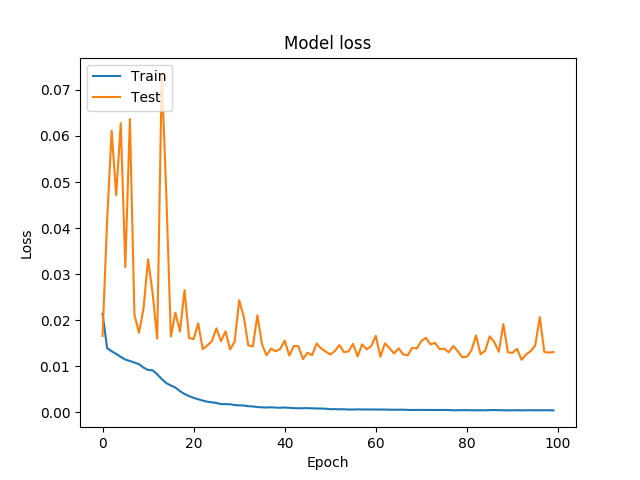

In [56]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
